# Verification and study of the general geometric imaging equation

The goal of this notebook is to:

1. Verify the accuracy of the general geometric imaging equation in Scheimpflug configuration by comparing the numerically computed image points against the corresponding image points obtained via ray tracing in Zemax, and
2. Study the geometric properties of images influenced by rotation of lens and sensor along with pupil magnification.

## Index

1. [Part I: Verification of the equation](#Part-I:-Verification-of-the-equation)
2. [Part-II: Properties of image field under lens and sensor rotations](#Part-II:-Properties-of-image-field-under-lens-and-sensor-rotations)

In the next few cells we have imported the required Python libraries and written a few helper functions that will be used in both part I and part II of this computational notebook.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [29]:
from __future__ import division, print_function
import os
import gc
import numpy as np
import h5py as hdf
from scipy.misc import imread, imsave
import pyzdde.zdde as py
import pyzdde.arraytrace as at
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colorbar import make_axes
import matplotlib.patches as mpatches
import IPython.display as display

%aimport geometric_model_zemax_commons
import geometric_model_zemax_commons as gm

# local modules
import iutils.plot.mplutils as mplu

%matplotlib inline

curDir = os.getcwd()

In [7]:
# Helper functions common to both Part-I and Part-II of this computational notebook.

# NOTE: In this document the "PIVOT" is the pivot of the lens group

def find_surf_using_comment(ln, comment):
    for i in range(ln.zGetNumSurf()):
        if ln.zGetComment(i) == comment:
            break
    else:
        return -1
    return i

def get_pupil_pos_from_pivot(ln):
    """returns the distance of the ENPP and EXPP from the PIVOT (de and deDash)
    """
    ln.zGetUpdate()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    enppSurf = find_surf_using_comment(ln, 'ENPP')
    exppSurf = find_surf_using_comment(ln, 'EXPP')

    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    enppZ = ln.zOperandValue('GLCZ', enppSurf) - pivotZ
    exppZ = ln.zOperandValue('GLCZ', exppSurf) - pivotZ
    return enppZ, exppZ, pivotZ

def get_image_pos_from_pivot(ln):
    """returns the distance of the image plane from the pivot along z-direction (zoDash)
    """
    ln.zGetUpdate()
    imaSurf = ln.zGetNumSurf()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    imaZ = ln.zOperandValue('GLCZ', imaSurf) - pivotZ
    return imaZ

def get_obj_pos_from_pivot(ln):
    """returns the distance of the object point/plane from the pivot along z-direction (zo)"""
    ln.zGetUpdate()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    objZ = ln.zOperandValue('GLCZ', 0) - pivotZ
    return objZ

def set_lens_image_rotations(ln, thetaXLens, thetaYLens, thetaXImage, thetaYImage, cbLens, cbImage):
    """sets the lens and image plane rotation angles
    """
    ln.zSetSurfaceParameter(cbLens, 3, thetaXLens)
    ln.zSetSurfaceParameter(cbLens, 4, thetaYLens)
    ln.zSetSurfaceParameter(cbImage, 3, thetaXImage)
    ln.zSetSurfaceParameter(cbImage, 4, thetaYImage)
    ln.zGetUpdate()
    
def rotX(angle):
    """returns 3D matrix in SO(3) for rotating a vector about the +x-axis
    @param : angle in degrees
    """
    c, s = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    return np.array([[1.0, 0.0, 0.0], [0.0, c, -s], [0.0, s, c]])

def rotY(angle):
    """returns 3D matrix in SO(3) for rotating a vector about the +y-axis
    @param : angle in degrees
    """
    c, s = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    return np.array([[c, 0.0, s], [0.0, 1, 0.0], [-s, 0, c]])

In [8]:
# Helper function for saving figures
imgdir = os.path.join(curDir, 'images')
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    print("Created 'images' directory")


bSaveFigure = True
fig_format, fig_ext = 'png', '.png'
def saveFigure(figure, fig_name, DPI=200):
    if bSaveFigure:
        figname = os.path.join(imgdir, fig_name)
        print('figname:', figname)
        figure.savefig(figname, dpi=DPI, facecolor='white', edgecolor='white',
                       bbox_inches='tight', format=fig_format, pad_inches=0.03)

## Part I: Verification of the equation

In this section we are going to verify the accuracy of geometric imaging equation in Scheimpflug configuration. The equation, given as follows, relates an object point with its corresponding image point.

$$
\acute{{\bf x}} = \acute{d}_e \, {\bf r} _{l,3} + 
\frac{\left( \hat{{\bf n}}_i (3) \, \acute{z}_o  - \acute{d}_e \, \hat{{\bf n}}_i^T \, {\bf r} _{l,3} \right)}{\hat{{\bf n}}_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3})}
R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3}) \,\,
$$


In the above equation both the object point and the image point are represented with respect to the camera frame ${C}$. 

$$
^{c}\acute{{\bf x}} = R_i \, ^{i}\acute{{\bf x}} + {\bf t}_i
$$

where, ${\bf t}_i = [0, 0, \acute{z}_o]^T$

Therefore, the coordinates of the image point in the image frame is


$$
^{i}\acute{{\bf x}} = R^T_i \,\left( ^{c}\acute{{\bf x}} - {\bf t}_i \right)
$$


The image point in the image frame is then given as:

$$
^{i}\acute{{\bf x}} = R_i^T \left( \acute{d}_e \, {\bf r} _{l,3}  - {\bf t}_i \right)  + 
\frac{\left( \hat{{\bf n}}_i (3) \, \acute{z}_o  - \acute{d}_e \, \hat{{\bf n}}_i^T \, {\bf r} _{l,3} \right)}{\hat{{\bf n}}_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3})}
R_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3}) \,\,
$$



In order to verify the above equations, we will first construct an aberration-free lens in Zemax. We will use two paraxial surfaces to construct a lens that represents a paraxial double lens model. 



The *equvalent* or *effective" focal-length $f$ of the two-lens system is [Kingslake, 2009]:

$$
\frac{1}{f} = \frac{1}{f_1} + \frac{1}{f_2} - \frac{s}{f_1 f_2}  \, .
$$

where $s$ is the separation between the two lenses.  

Furthermore, the pupil magnification of the double lens can be varied using the relation (refer to the notebook [Pupil Magnification Study](PupilMagnificationStudy.ipynb)):

$$
m_p = \left(\frac{f_2}{f_1}\right) \frac{a - f_1}{s - a - f_2} \, .
$$

where, $a$ is the distance between the first lens and the limiting aperture of the lens system.


The following code cells require a running Zemax application.

In [17]:
# Location of the Zemax lens files for this notebook
zmxdir = os.path.join(curDir, 'zmxfiles')
ln = pyz.createLink()

In [18]:
# The lens "paraxialDoubleLens24mmFiniteConj_mp2.zmx" was created separately in Zemax application
# It has an effective focal length of 24 mm, and a pupil magnification of 2. In frontoparallel
# configuration, the lens is focused on an object plane 500 mm away.
# Note that the field for the lens is specified as "Object hegiht" 

lens = "paraxialDoubleLens24mmFiniteConj_mp2.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)

0

In [19]:
# The lens surfaces
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ STANDARD       Infinity            500                                200              0
   1 PARAXIAL              -       3.636364                           9.382086              - Lens 1
 STO STANDARD       Infinity       16.36364                           7.142857              0 Stop
   3 PARAXIAL              -       13.17073                           11.35204              - Lens 2
 IMA STANDARD       Infinity                                          9.756098              0


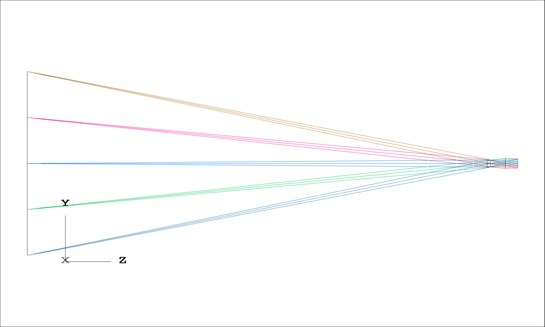

In [20]:
# Layout plot
ln.ipzCaptureWindow('L3d')

In [21]:
# First order parameters
ln.ipzGetFirst()

Paraxial magnification : -0.0487804878
Real working F/#       : 3.168743031
Effective focal length : 24.0
Paraxial working F/#   : 3.129046563
Paraxial image height  : 4.87804878


In [22]:
# Pupil information
ln.ipzGetPupil()

Exit pupil position (from IMA)           : -49.17073171
Entrance pupil position (from surface 1) : 4.0
Aperture Type                            : Float by stop
Apodization factor                       : 0.0
Apodization type                         : None
Value (stop surface semi-diameter)       : 3.571428571
Exit pupil diameter                      : 15.71428571
Entrance pupil diameter                  : 7.857142857


In [23]:
# Pupil magnification
ln.zGetPupilMagnification()

1.999999999490909

Before we begin to verify, we will insert (dummy) surfaces in the lens to represent the entrance and exit pupils, and the cardinal planes. Drawing the cardinal planes helps us to visually ensure several things such as ensuring that we have indeed traced the chief-rays from the object (these rays must converge at the center of the entrance pupil and re-emerge from the center of the exit pupil). It also helps us to visually verify the point of rotation of the lens (whether it is about the entrance pupil center or about a point away from the entrance pupil).

Note:
Although the locations of these paraxial planes are reported in Zemax, there is no option to render them; so we use dummy surfaces to represent them. However, we need to ensure that Zemax doesn't trace rays to these surfaces.  

In [24]:
# Draw ENPP, EXPP and cardinal surfaces
gm.draw_pupil_cardinal_planes(ln, firstDummySurfOff=20, push=True)

Textual information about the planes:

Exit pupil distance from IMG: -49.17073171
Entrance pupil from Surf 1 @ LDE: 24.0
Focal plane obj F from surf 1 @ LDE:  12.0 
Focal plane img F' from IMA:  -1.170732
Principal plane obj H from surf 1 @ LDE:  36.0 
Principal plane img H' from IMA:  -25.170732
Focal length:  24.0
Principal plane H to ENPP:  12.0
Principal plane H' to EXPP:  23.99999971
Principal plane H' to EXPP (abs.) calc. using lens equ.:  24.0
Principal plane H' to rear focal plane:  24.0
Principal plane H to front focal plane:  -24.0

Check "Skip rays to this surface" under "Draw Tab" of the surface property for the dummy and cardinal plane surfaces. See Docstring Notes for details.


In [25]:
# After making the required changes to the surface properties (skip rays) in the Zemax main application window, 
# the file with the new surfaces to show the position of the pupils and cardinal planes was saved as
# paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawn.zmx
# In order to avoid the drudgery of manually checking "skip rays to surface" every time, we use a stored copy.

loadStoredCopy = True

if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawn.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()

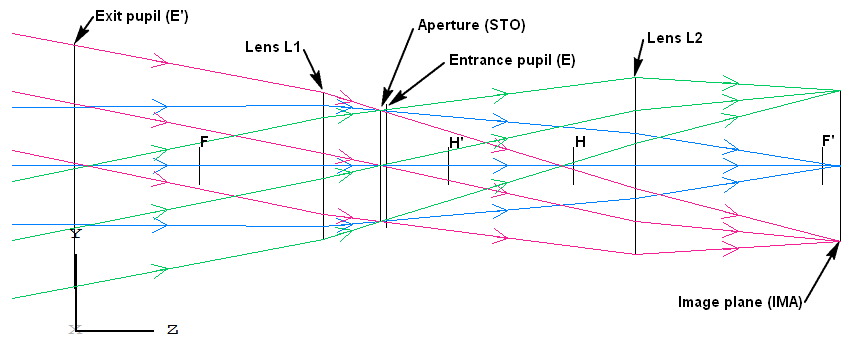

In [30]:
# Annotated figure of the double lens (after adding the dummy surfaces to represent cardinal planes)
# The object plane is not shown for visual clarity.
display.Image('./images/lens_24mm_mp2_with_cardinals.png')

In [31]:
# Insert appropriate coordinate breaks to tilt the lens
# Note that the "lens" consists of many surfaces -- some physical (aperture, elemental lens surfaces L1, L2), 
# and some virtual (the cardinal planes, entrance and exit pupil). When we physically rotate a "lens" about 
# a point, all the associates surfaces also rotate about this point. Therefore, in Zemax, we will need to 
# include all the surfaces with coordinate breaks in order to rotate them together. 

# For this example, we will rotate the lens about a point that is 5 mm away from the entrance pupil. 

imgPPSurf = find_surf_using_comment(ln, "H'")
cb1, cb2 = gm.insert_cbs_to_tilt_lens(ln, lastSurf=imgPPSurf, firstSurf=2, pivot='ENPP', offset=5, push=True)
cb1, cb2

(4, 20)

As before, we need to do the following in the main Zemax application:

1. Check the "Skip rays to this surface" (in the "Draw Tab" under surface properties) for the two dummy surfaces just inserted -- one preceding the first CB (with comment "Move to pivot ...") and second following the second CB.

2. Fix the semi-diameters of the ENPP and EXPP surfaces so that they don't change when the lens rotates.

3. Ensure that the global reference surface is either the PIVOT surface (recommended), image plane or the untilted object plane.

4. Also, ensure that you are rendering all the appropriate surfaces in the 3D Layout plot. That is, select "First surface" as "1-dummy 2 c rays", and "Last surface" as "IMA" surface (in this case it is surface number 22). 

We will store a copy of the lens with the current configuration settings so that we don't have to do it manually again if we have to repeat the experiment. The name used to store the current settings is "paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawnWdRotAboutENPPplusOffset.zmx"

In [88]:
loadStoredCopy = True

if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawnWdRotAboutENPPplusOffset.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
    cb1 = 4
else:
    # If a different lens is used ... 
    ln.zGetRefresh()

<font color='red'>**Important!**</font> 

1. Before we perform any ray tracing to plot the intersection of the chief-ray(s) with the image plane, we must ensure that the (paraxial) *ray-aiming* feature in Zemax is turned on. This is important because during ray tracing Zemax determines the direction cosines of the rays that emerges from the object surface based on the paraxial entrance pupil location. However, the **paraxial calculation used to compute the entrance pupil ignores tilts and decenters of the surfaces including the stop**. Therefore, it is very likely that a "chief-ray", which is defined as the ray through the center of the stop (and virtually through the centers of the entrance and exit pupils in an aberration-free optical system), may not be traced if the ray aiming is not on.

2. The coordinates (of ray intersection with a surface) returned by `zGetTrace()` are with respect to the surface's reference frame instead of the global reference frame. Therefore, if the image surface is a plane (which is the case here) the z-component of the ray intersection with the surface will be zero.   

In [89]:
# Set ray-aiming 
sysProp = ln.zGetSystem()
ln.zSetSystem(unitCode=sysProp.unitCode, 
              stopSurf=sysProp.stopSurf, 
              rayAimingType=1, 
              globalRefSurf=sysProp.globalRefSurf)

(22, 0, 12, 1, 1, 0, 20.0, 1, 3)

In [104]:
# The maximum field height set originally in the lens file is 100 mm. We will change the maximum 
# field height to a value (equal to 92.25 mm) since, later in the notebook, we can compare this plot
# with a plot obtained by numerically computing the image field for exactly this lens rotation.

ln.zSetField(0, 1, 5, 0) # 5 fields defined by object height, and radial field normalization.
ln.zSetField(2, 92.25, 0)
ln.zSetField(3, -92.25, 0)
ln.zSetField(4, 0, 92.25)
ln.zSetField(5, 0, -92.25)
ln.zGetUpdate()

#### Chief ray intersection plots

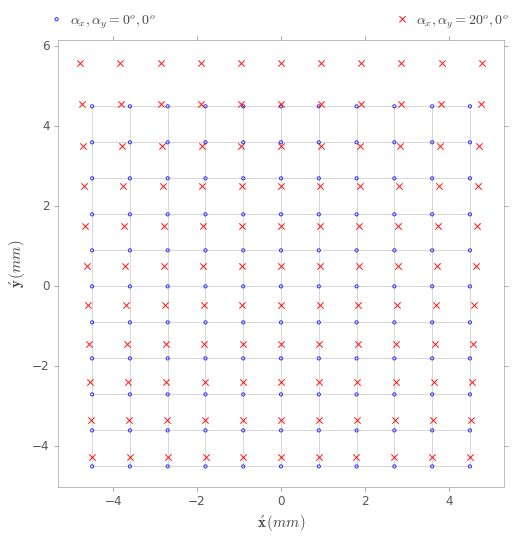

In [95]:
# Chief ray intersection plot 1: 
# the lens is tilted about the pivot point by 20° about the x-axis while 
# keeping the image plane perpendicular to the z-axis

# the blue circles represents the points of intersection of the cheif rays with the image plane in 
# frontoparallel configuration (when the lens and/or image planes are not tilted)

tiltXY = [(0,0), (20, 0)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

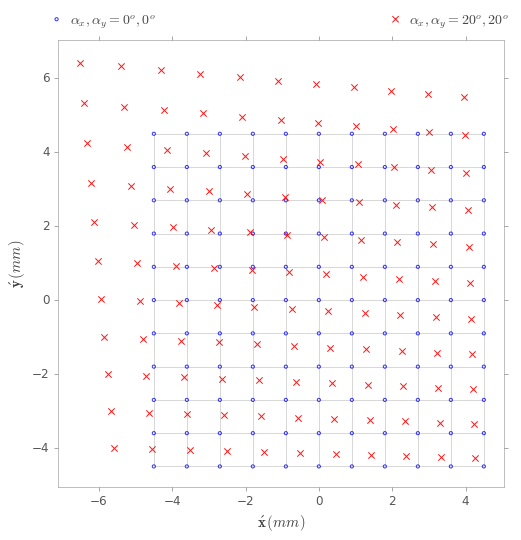

In [96]:
# Chief ray intersection plot 2: 
# the lens is tilted about the pivot point by 20° about both x-axis while 
# keeping the image plane perpendicular to the z-axis of the camera frame.
tiltXY = [(0,0), (20, 20)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

Now, we will also tilt the image plane. But before we can do that, we will need to insert a coordinate break before the image surface.

In [97]:
# insert coordinate break and tilt image surface by 15°
imaSurf = ln.zGetNumSurf()
ln.zInsertCoordinateBreak(surfNum=imaSurf, xtilt=15.0)

0

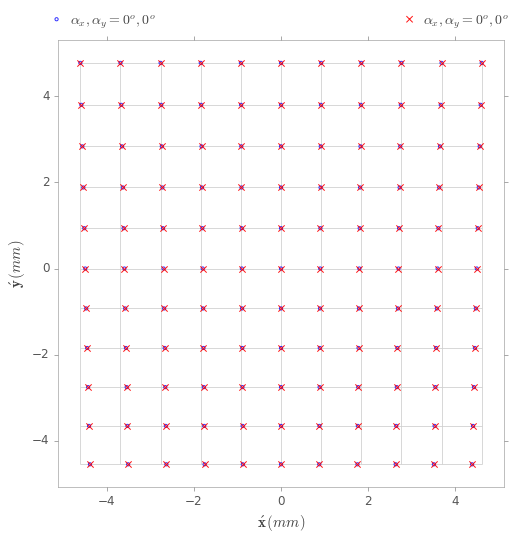

In [98]:
# Chief ray intersection plot 3: 
# The image plane is tilted by 15° and the lens is in nominal position (not rotated)  
# Note that now the blue circles are also distorted representing the tilt of the image plane
tiltXY = [(0,0), (0, 0)]  # no lens tilt
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

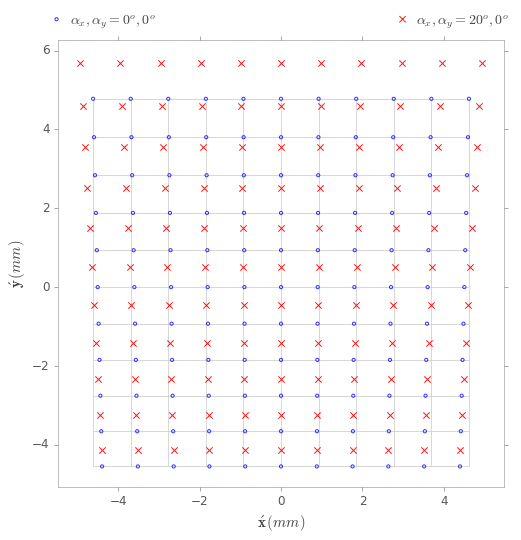

In [99]:
# Chief ray intersection plot 4: 
# The image plane is tilted by 15° and the lens is rotated about the pivot about the x-axis by 20°

tiltXY = [(0,0), (20, 0)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

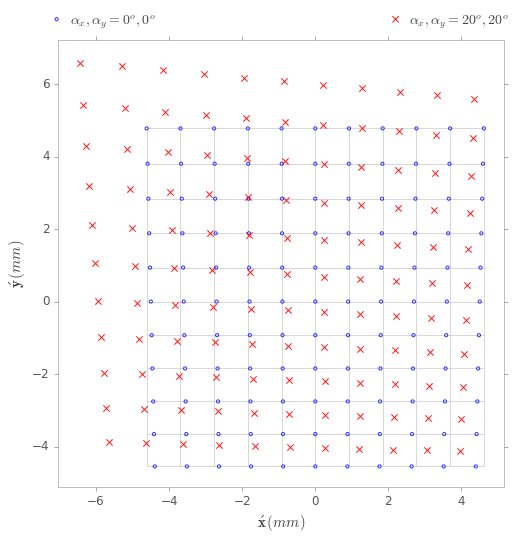

In [100]:
# Chief ray intersection plot 5: 
# The image plane is tilted by 15° and the lens is rotated about the pivot about both the x- and y- axes by 20°

tiltXY = [(0,0), (20, 20)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

Now, we will compare the Zemax's ray traced values with that computed numerically using the equations. We will write the equations again here for convenience.

Verification of the equation:

In [107]:
# Set the fields to 100 x 100 mm square @ object space
ln.zSetField(2, 100, 0)
ln.zSetField(3, -100, 0)
ln.zSetField(4, 0, 100)
ln.zSetField(5, 0, -100);
ln.zGetUpdate()

0

In [108]:
# create field coordinates for ray tracing
# NOTE: 
# The following field definitions in the LDE are assumed:
# 1. The field normalization is RADIAL
# 2. The field type is object height

fieldDef = ln.zGetField(0)
assert fieldDef.type == 1       # ensure type is object height
assert fieldDef.normMethod == 0 # ensure radial normalization

# maximum radial field
fR = fieldDef.maxX # or maxY
fR

100.0

In [111]:
## Get the positions of the ENPP, EXPP and Image plane w.r.t. the pivot
## Get the pupil magnification mp

cb1Lens = cb1                    
cbImage = ln.zGetNumSurf() - 1  

# first ensure that the lens is not rotated
set_lens_image_rotations(ln, 0, 0, 0, 0, cb1Lens, cbImage)

zo = get_obj_pos_from_pivot(ln)
zoDash = get_image_pos_from_pivot(ln)
de, deDash, pp = get_pupil_pos_from_pivot(ln)
mp = ln.zGetPupilMagnification()

print('Pivot position:', pp)
print('ENPP position (de):', de)
print('EXPP position (deDash):', deDash)
print('Obj. plane position from pivot position:', zo)
print('Image position (zoDash):', zoDash)
print('Pupil magnification (mp):', mp)

Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -25.0
Obj. plane position from pivot position: -509.0
Image position (zoDash): 24.1707317
Pupil magnification (mp): 1.99999999949


In [112]:
## Set the elemental rotations of the lens and image plane @ Zemax
# note that in Zemax the rotations are intrinsic, i.e. rotations subsequent to 
# the first rotation is always w.r.t. the new x-y-z axis.
# Also, if the order flag in the first coordinate break is 0 (default), then the
# order of rotations is: x-y'-z"

thetaXLens, thetaYLens = -20, 10
thetaXImage, thetaYImage = 15, -5
set_lens_image_rotations(ln, thetaXLens, thetaYLens, thetaXImage, thetaYImage, cb1Lens, cbImage)

In [113]:
#ln.zPushLens()

In [114]:
# Construct intrinsic rotation matrix  x-y'-z"
# This is equivalent to composition of extrinsic elemental rotations: z-y-x

Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
rl3 = Rl[:,2] # optical axis
Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
ni = Ri[:, 2] # normal to the image plane

In [115]:
# Verify using ray-tracing in Zemax
# Ensure that "ray-aiming" is on

assert ln.zGetSystem().rayAimingType
z = get_obj_pos_from_pivot(ln)
normObjPts = np.array([[ 0.0000,  0.0000], 
                       [ 0.1000, -0.1000],
                       [-0.5000,  0.5000],
                       [ 0.7071,  0.7071],
                       [ 1.0000,  0.0000],
                       [ 0.0000,  1.0000],
                       [ 1.0000,  1.0000]
                       ])

Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
numr = ni[2]*zoDash - deDash*np.dot(ni, rl3)
rmrt = np.dot(Rl , np.dot(Mp, Rl.T))

print('\t  X\t\t\t    x_computed\t\t   x_ray_trace\t\t  err(delx, dely)')
for pts in normObjPts:
    X = np.hstack((fR*pts, [z,]))
    A =  np.dot(rmrt, X - de*rl3)
    deno = np.dot(ni, A)
    x_c_est = deDash*rl3 + (numr/deno)*A   # estimate of x in camera frame
    x_est = np.dot(Ri.T, (x_c_est - np.array([0, 0, zoDash]).T))  # estimate of x in the image frame
    
    # ray trace
    rt = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=pts[0], hy=pts[1], px=0, py=0)
    print('({: 7.2f}, {: 7.2f}, {: 5.1f}) '
          '({: .4f}, {: .4f}, {: .1f}) '
          '({: .4f}, {: .4f}, {: .1f}) '
          '({:0.1e}, {:0.1e}, {:0.1e})'
          .format(X[0], X[1], X[2],
                  x_est[0], x_est[1], x_est[2],
                  rt.x, rt.y, rt.z, 
                  abs(x_est[0] - rt.x), abs(x_est[1] - rt.y), abs(x_est[2] - rt.z)))

	  X			    x_computed		   x_ray_trace		  err(delx, dely)
(   0.00,    0.00, -509.0) (-0.3108, -0.6291,  0.0) (-0.3108, -0.6291,  0.0) (1.8e-09, 3.1e-09, 7.5e-15)
(  10.00,  -10.00, -509.0) (-0.8003, -0.0863, -0.0) (-0.8003, -0.0863,  0.0) (2.1e-09, 2.7e-09, 3.0e-15)
( -50.00,   50.00, -509.0) ( 2.1291, -3.3352,  0.0) ( 2.1291, -3.3352,  0.0) (1.2e-09, 3.2e-09, 2.9e-15)
(  70.71,   70.71, -509.0) (-4.2013, -5.0221, -0.0) (-4.2013, -5.0221,  0.0) (2.6e-09, 5.1e-09, 4.7e-15)
( 100.00,    0.00, -509.0) (-5.5251, -1.0101, -0.0) (-5.5251, -1.0101,  0.0) (1.3e-09, 8.4e-09, 3.1e-15)
(   0.00,  100.00, -509.0) (-0.6031, -6.4387, -0.0) (-0.6031, -6.4387,  0.0) (2.2e-09, 4.0e-09, 2.2e-16)
( 100.00,  100.00, -509.0) (-5.8238, -6.8542,  0.0) (-5.8238, -6.8542,  0.0) (5.6e-10, 2.5e-10, 2.2e-15)


From the above comparison, we can observe that the numerically computed values of image points are equal to those generated using ray tracing for all practical purposes. 

In [116]:
ln.close()

## Part-II: Properties of image field under lens and sensor rotations 

First we need to find the distances of the ENPP and EXPP from the PIVOT (of the lens group) point. The following block of code is used to retrieve this information. Note that it requires Zemax in running state.

Please make sure that there is no unsaved file in the Zemax DDE server, the following block of code will load files erasing any unsaved file that is present in the DDE server.

In [43]:
# Execute this cell only if Zemax is not already running
ln = pyz.createLink()

In [48]:
# This cell requires a running Zemax  application
def print_pupil_distances_from_lens_pivot_point(pivotOffset=5):
    """
    @param : pivotOffset (real) : offset of the lens group pivot point from the ENPP
    """
    # all of the following lenses files have very similar imaging parameters, such as 
    # exact focal length, 500 mm object plane from the first surface of the lens (this)
    # doesn't necessarily mean that obj-to-entrance-pupil distances are equal.
    lensFiles = ["paraxialDoubleLens24mmFiniteConj_mp1.zmx",
                 "paraxialDoubleLens24mmFiniteConj_mp2.zmx",
                 "paraxialDoubleLens24mmFiniteConj_mpdot55.zmx"]

    zmxdir = os.path.join(curDir, 'zmxfiles')
    for lens in lensFiles:
        lensPath = os.path.join(zmxdir, lens)
        ln.zLoadFile(lensPath)

        # draw cardinal and pupil planes
        gm.draw_pupil_cardinal_planes(ln, firstDummySurfOff=20, push=True, printInfo=False)

        # insert CBs
        imgPPSurf = find_surf_using_comment(ln, "H'")
        objPPSurf = find_surf_using_comment(ln, "H")
        cb1, cb2 = gm.insert_cbs_to_tilt_lens(ln, lastSurf=imgPPSurf, firstSurf=objPPSurf-1, 
                                              pivot='ENPP', offset=pivotOffset, push=True)

        # change Global reference surface to the PIVOT surface
        pivotSurf = find_surf_using_comment(ln, 'PIVOT')
        sysProp = ln.zGetSystem()
        _ = ln.zSetSystem(unitCode=sysProp.unitCode, 
                          stopSurf=sysProp.stopSurf, 
                          rayAimingType=sysProp.rayAimingType, 
                          globalRefSurf=pivotSurf)
        # retrieve and print data
        zo = get_obj_pos_from_pivot(ln)
        zoDash = get_image_pos_from_pivot(ln)
        de, deDash, pp = get_pupil_pos_from_pivot(ln)
        mp = ln.zGetPupilMagnification()
        
        # compare the values with the function pupil_centric_lens_formula()
        # ... actually to verify the this function
        ze = abs(zo - de) # object distance from ENPP
        zeDash = gm.pupil_centric_lens_formula(u=ze, v=None, f=24.0, mp=mp).v # image distance from EXPP
        assert abs(zeDash - abs(zoDash - deDash)) < 1e-6, \
        'zeDash = {:2.6f}, |zoDash - deDash| = {:2.6f}'.format(zeDash, abs(zoDash - deDash))
        
        print('\nLens:', lens)
        print('==============================================')
        print('Pupil magnification (mp):', mp)
        print('Pivot position:', pp)
        print('ENPP position (de):', de)
        print('EXPP position (deDash):', deDash)
        print('Obj. plane position (zo):', zo)
        print('Image position (zoDash):', zoDash)
        print('Obj. distance from ENPP (|ze|):', ze)
        print('Image position from EXPP (|zeDash|):', zeDash)

In [49]:
# This cell requires a running Zemax  application
# Offset of lens group PIVOT point from ENPP = 5 mm
print_pupil_distances_from_lens_pivot_point(pivotOffset=5)


Lens: paraxialDoubleLens24mmFiniteConj_mp1.zmx
Pupil magnification (mp): 1.0
Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -13.0
Obj. plane position (zo): -521.0
Image position (zoDash): 12.1707317
Obj. distance from ENPP (|ze|): 516.0
Image position from EXPP (|zeDash|): 25.1707317073

Lens: paraxialDoubleLens24mmFiniteConj_mp2.zmx
Pupil magnification (mp): 1.99999999949
Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -25.0
Obj. plane position (zo): -509.0
Image position (zoDash): 24.1707317
Obj. distance from ENPP (|ze|): 504.0
Image position from EXPP (|zeDash|): 49.1707316951

Lens: paraxialDoubleLens24mmFiniteConj_mpdot55.zmx
Pupil magnification (mp): 0.55000000037
Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -21.8363636
Obj. plane position (zo): -540.636364
Image position (zoDash): -7.4656319
Obj. distance from ENPP (|ze|): 535.636364
Image position from EXPP (|zeDash|): 14.3707317153


In [50]:
# This cell requires a running Zemax  application
# Offset of lens group PIVOT point from ENPP = 0 mm
print_pupil_distances_from_lens_pivot_point(pivotOffset=0)


Lens: paraxialDoubleLens24mmFiniteConj_mp1.zmx
Pupil magnification (mp): 1.0
Pivot position: 0.0
ENPP position (de): 0.0
EXPP position (deDash): -8.0
Obj. plane position (zo): -516.0
Image position (zoDash): 17.1707317
Obj. distance from ENPP (|ze|): 516.0
Image position from EXPP (|zeDash|): 25.1707317073

Lens: paraxialDoubleLens24mmFiniteConj_mp2.zmx
Pupil magnification (mp): 1.99999999949
Pivot position: 0.0
ENPP position (de): 0.0
EXPP position (deDash): -20.0
Obj. plane position (zo): -504.0
Image position (zoDash): 29.1707317
Obj. distance from ENPP (|ze|): 504.0
Image position from EXPP (|zeDash|): 49.1707316951

Lens: paraxialDoubleLens24mmFiniteConj_mpdot55.zmx
Pupil magnification (mp): 0.55000000037
Pivot position: 0.0
ENPP position (de): 0.0
EXPP position (deDash): -16.8363636
Obj. plane position (zo): -535.636364
Image position (zoDash): -2.4656319
Obj. distance from ENPP (|ze|): 535.636364
Image position from EXPP (|zeDash|): 14.3707317153


In [51]:
# This cell requires a running Zemax  application
ln.close()

Since we now have the required parameters (mainly $d_e$ and $\acute{d}_e$) for the systems that we can use with the Scheimpflug imaging equation, we don't need to use Zemax to study the geometric properties of the image field under rotations of the lens and sensor planes.  

The following sections of the code can run without Zemax running.

In [9]:
def get_image_coordinates(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash):
    """returns the coordinates of the chief-ray-image-plane intersections in the image surface
    reference frame
    
    Parameters
    ----------
    X : ndarray
        3xN array of object coordinates (in camera frame)
    
    
    """
    # construct lens rotation matrix and optical axis vector
    Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
    rl3 = Rl[:, 2, np.newaxis]  # optical axis
    # construct image plane rotation matrix and image plane normal
    Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
    ni = Ri[:, 2, np.newaxis]   # normal to the image plane
    # pupil magnification matrix
    Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
    numr = ni[2]*zoDash - deDash*np.dot(ni.T, rl3)
    rmrt = np.dot(Rl , np.dot(Mp, Rl.T))
    A =  np.dot(rmrt, X - de*rl3)  # [A]=3xn
    deno = np.dot(ni.T, A)    # [deno]=1xn
    x_c = deDash*rl3 + (numr/deno)*A   # x in camera frame
    x_i = np.dot(Ri.T, (x_c - np.array([[0, 0, zoDash]]).T))  # x in the image frame
    return x_i

# implementation of the second expression (equivalent)

def get_image_coordinates_v2(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash):
    """returns the coordinates of the chief-ray-image-plane intersections in the image surface
    reference frame
    
    Parameters
    ----------
    X : ndarray
        3xN array of object coordinates (in camera frame)
    
    
    """
    # construct lens rotation matrix and optical axis vector
    Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
    rl3 = Rl[:, 2, np.newaxis]  # optical axis
    # construct image plane rotation matrix and image plane normal
    Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
    ti = np.array([[0, 0, zoDash]]).T
    #ri3 = Ri[:, 2, np.newaxis]   # same as ni
    ni = Ri[:, 2, np.newaxis]   # normal to the image plane
    # pupil magnification matrix
    Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
    numr = ni[2]*zoDash - deDash*np.dot(ni.T, rl3)
    rmrt = np.dot(Rl , np.dot(Mp, Rl.T))
    A =  np.dot(rmrt, X - de*rl3)  # [A]=3xn
    deno = np.dot(ni.T, A)    # [deno]=1xn 
    
    x_i = np.dot(Ri.T, (deDash*rl3 - ti)) + (numr/deno)* np.dot(Ri.T, A)  # x in image frame
    return x_i

In [10]:
z = -509.0   # mm
fR= 100      # abs. max field height  
de = -5.0
deDash = -25.0
zoDash = 24.1707317
mp = 2.0

# normalized field coordinate grid
nx = [-1.0, -0.98, -0.7071, -0.5, -0.25, -0.15, 0.0, 0.15, 0.25, 0.5, 0.7071, 0.98, 1.0]
n = len(nx)
hx, hy = np.meshgrid(nx, nx)
X = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), z*np.ones((1, n**2))))

#
thetaXLens, thetaYLens =  5., 10.
thetaXImage, thetaYImage =  5, -2
x1 = get_image_coordinates(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x2 = get_image_coordinates_v2(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)

assert np.sum(x1 - x2) < 10e-10

print("The two functions are equivalent (w.r.t. the tested points)!")

The two functions are equivalent (w.r.t. the tested points)!


#### Plots: Type 1

In these plots, we have two object planes that are positioned (COMPLETE THE DESCRIPTION) ...

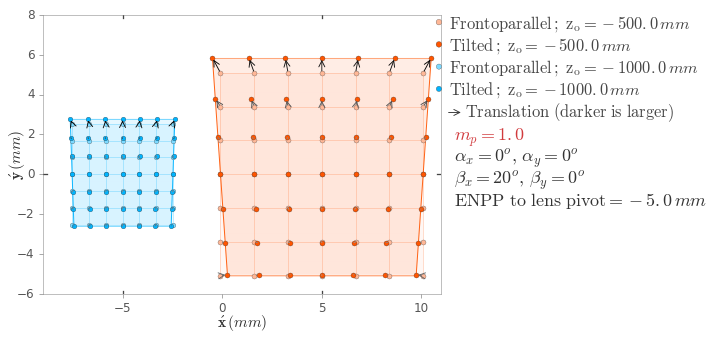

In [11]:

# normalized field coordinates (common for all the optical systems)
n = 7   # THIS NUMBER SHOULD BE ODD, in order to have the on-axis point (0,0)
nx = np.linspace(-1, 1, n)
hx, hy = np.meshgrid(nx, nx)
fR= 100 

# for drawing the outer boundary
nB = 15
nxB = np.linspace(-1, 1, nB)    
hxB, hyB = np.meshgrid(nxB, nxB)

# *****************************
#       PLOT SETTINGS
# ****************************
# Set optical system
OPTICAL_SYSTEM = 2  # mp(1)=0.55 , mp(2)=1.0 or mp(not(1,2))=2.0
PIVOT_OFFSET = 5    # 0 or 5 mm from the ENPP (actual offset is -5)
COMPARE_PIVOT_OFFSET = False   # set OPTICAL_SYSTEM=2 set the particular PIVOT_OFFSET value = 0
TILT_UNOFFSET = False
SHOW_COMMON_LEGEND = True # generally true only for the first image in a squence
# ******************************

## Set tilts
if COMPARE_PIVOT_OFFSET:
    # to compare Pivot offset
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 0, 0 # with Pivot_offset = 0, mp=1
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 5, 5 # with Pivot_offset = 0, mp=1
    thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 0, 0 # with Pivot_offset = 5, mp=1
else:
    thetaXLens, thetaYLens, thetaXImage, thetaYImage =  0, 0, 20, 0
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  5, 0, 0, 0
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  5, 0, 20, 0

assert PIVOT_OFFSET in (0, 5)

if OPTICAL_SYSTEM == 1: # mp = 0.550000000
    # Optical System 1
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -21.8363636 if PIVOT_OFFSET else -16.8363636
    zoDash = -7.4656319 if PIVOT_OFFSET else -2.4656319
    mp = 0.55
elif OPTICAL_SYSTEM == 2: # mp = 1.0
    # Optical System 2
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -13.0 if PIVOT_OFFSET else -8.0
    zoDash = 12.1707317 if PIVOT_OFFSET else 17.1707317
    mp = 1.0
else: # mp = 2.0
    # Optical System 3
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -25.0 if PIVOT_OFFSET else -20.0
    zoDash = 24.1707317 if PIVOT_OFFSET else 29.1707317
    mp = 2.0

# Object planes (zFar and zNear have nothing to do with DOF, they are just two planes in object space)
#zNear = -509.0  
#zFar = -809.0

zNear = -500.0
zFar = -1000.0


# COMPUTATOINS
# ###########

# points @ object plane Z1
XNear = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), zNear*np.ones((1, n**2))))
XNearB = np.vstack((fR*hxB.reshape(1, nB**2), fR*hyB.reshape(1, nB**2), zNear*np.ones((1, nB**2))))

# image points for zero tilts @ object plane Z1
x1 = get_image_coordinates(XNear, 0, 0, 0, 0, mp, zoDash, de, deDash)
x1B = get_image_coordinates(XNearB, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z1
x2 = get_image_coordinates(XNear, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x2B = get_image_coordinates(XNearB, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)

# points @ object plane Z2
XFar = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), zFar*np.ones((1, n**2))))
XFarB = np.vstack((fR*hxB.reshape(1, nB**2), fR*hyB.reshape(1, nB**2), zFar*np.ones((1, nB**2))))

# image points for zero tilts @ object plane Z2 
x3 = get_image_coordinates_v2(XFar, 0, 0, 0, 0, mp, zoDash, de, deDash)
x3B = get_image_coordinates_v2(XFarB, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z1
x4 = get_image_coordinates_v2(XFar, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x4B = get_image_coordinates_v2(XFarB, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)


# compensation for tilt offset
tOffset = x2[:2, n**2 // 2] - x1[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 
#tOffset = x4[:2, n**2 // 2] - x3[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 

# displacement of center of mass of block @ Z1
cmDisplaceZ1x = np.sum(x2[0, :]/n**2) - np.sum(x1[0, :]/n**2)
cmDisplaceZ1y = np.sum(x2[1, :]/n**2) - np.sum(x1[1, :]/n**2)

# displacement of center of mass of block @ Z2
cmDisplaceZ2x = np.sum(x4[0, :]/n**2) - np.sum(x3[0, :]/n**2)
cmDisplaceZ2y = np.sum(x4[1, :]/n**2) - np.sum(x3[1, :]/n**2)

#print('CM displace @ Z1 = ({:5f}, {:5f})'.format(cmDisplaceZ1x, cmDisplaceZ1y))
#print('CM displace @ Z2 = ({:5f}, {:5f})'.format(cmDisplaceZ2x, cmDisplaceZ2y))

# FIGURE
# ######

#fig, ax = plt.subplots(1, 1, figsize=(8.45, 5), dpi=200)
fig, ax = plt.subplots(1, 1, figsize=(8.45, 5.), dpi=200)

grid_col_notilt_z1 = '#FFB796'
grid_col_tilt_z1 = '#FF5500' #'#FF7433'
grid_col_notilt_z2 = '#7CD9FF' 
grid_col_tilt_z2 = '#00B4FF'


def get_v12NormMin_v12NormMax(a, b):
    v1 = np.hstack((a[0,:].reshape(n**2, 1), a[1,:].reshape(n**2, 1)))
    v2 = np.hstack((b[0,:].reshape(n**2, 1), b[1,:].reshape(n**2, 1)))
    v12Norm = np.linalg.norm(v2-v1, axis=1)
    return np.min(v12Norm), np.max(v12Norm)

def get_gray_level(vNorm, v12NormMin, v12NormMax):
    """
    Notes:
    where is vNorm in the scale between v12NormMin and v12NormMax?
    we can write: v12NormMin * (1 - a) + v12NormMax * a = vNorm
    Furthermore,
    if gl1 and gl2 are two gray levels (gl1 < gl2) and 0 <= gl1, gl2 <= 1
    gl = a * (gl2 - gl1) + gl1
    However, since we want darker shade to represent larger norm value,
    we return 1 - gl
    """
    deno = v12NormMax - v12NormMin
    a = (vNorm - v12NormMin)/deno if deno else 0.0
    gl1, gl2 = 0.35, 0.99
    gl = a * (gl2 - gl1) + gl1
    return 1.0 - gl


# Object plane at Z1
# ------------------
# displace plot for Z1 and Z2
xOffset, yOffset = 5, 0

ax.scatter(x1[0, :] + xOffset, x1[1, :] + yOffset, marker='o', s=25, 
           facecolors=grid_col_notilt_z1, edgecolors='#444444', lw=0.3, alpha=1.0, zorder=13,
           label=r'$\rm{{Frontoparallel}} \,;\,\,  z_o={}\, \it{{mm}}$'.format(zNear))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x1[0, i*n:(i+1)*n] + xOffset, 
                     y1=x1[1, i*n:(i+1)*n] + yOffset, 
                     y2=x1[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=grid_col_notilt_z1, edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x1[0, :][:n] + xOffset
yGridPts = x1[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=grid_col_notilt_z1, 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=grid_col_notilt_z1, 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x2[0, :] + xOffset - tOffset[0], x2[1, :] + yOffset - tOffset[1], 
           marker='o', s=25, facecolors=grid_col_tilt_z1, edgecolor='#333333', 
           lw=0.3, alpha=1.0, zorder=13, clip_on=False, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={}\, \it{{mm}}$'.format(zNear))

# shade region to show the span of the grid of points
for i in range(nB-1):
    x_row1 = x2B[0, i*nB:(i+1)*nB] + xOffset
    x_row2 = x2B[0, (i+1)*nB:(i+2)*nB] + xOffset
    y_row1 = x2B[1, i*nB:(i+1)*nB] + yOffset
    y_row2 = x2B[1, (i+1)*nB:(i+2)*nB] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=grid_col_tilt_z1, 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)


# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):    
    minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x1, x2)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x2[0, i] - x1[0, i])**2 +  (x2[1, i] - x1[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x2[0, i] + xOffset, x2[1, i] + yOffset), 
                    xytext=(x1[0, i] + xOffset, x1[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color=arrCol, linewidth=0.9, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)
    
# draw outer boundery
ax.plot(x2B[0, :nB] + xOffset - tOffset[0], x2B[1, :nB], color=grid_col_tilt_z1, 
        lw=0.9, zorder=2, alpha=0.5, clip_on=False) # top
ax.plot(x2B[0, -nB::] + xOffset - tOffset[0], x2B[1, -nB::], color=grid_col_tilt_z1, 
        lw=0.9, zorder=2, alpha=0.5,  clip_on=False) # bottom
ax.plot(x2B[0, nB-1::nB] + xOffset - tOffset[0], x2B[1, nB-1::nB], color=grid_col_tilt_z1, 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # left side
ax.plot(x2B[0, ::nB] + xOffset - tOffset[0], x2B[1, ::nB], color=grid_col_tilt_z1, 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # right side

if COMPARE_PIVOT_OFFSET:
    # displacement vector
    ax.annotate("", xy=(np.sum(x2[0, :]/n**2) + xOffset, np.sum(x2[1, :]/n**2) + yOffset), 
                xytext=(np.sum(x1[0, :]/n**2) + xOffset, np.sum(x1[1, :]/n**2) + yOffset),
                arrowprops=dict(fc='#68B04F', ec='#222222', linewidth=0.5, headwidth=15, width=7, alpha=0.9),
                annotation_clip=False, zorder=16)

# Object plane at Z2
# ------------------
xOffset, yOffset = -5, 0

ax.scatter(x3[0, :] + xOffset, x3[1, :] + yOffset, marker='o', s=22, 
           facecolors=grid_col_notilt_z2, edgecolors='#444444', lw=0.3, alpha=1.0, zorder=12,
           label=r'$\rm{{Frontoparallel}} \,;\, \, z_o={}\,\it{{mm}}$'.format(zFar))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x3[0, i*n:(i+1)*n] + xOffset, 
                     y1=x3[1, i*n:(i+1)*n] + yOffset, 
                     y2=x3[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=grid_col_notilt_z2, edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x3[0, :][:n] + xOffset
yGridPts = x3[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=grid_col_notilt_z2, 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=grid_col_notilt_z2, 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x4[0, :] + xOffset - tOffset[0], x4[1, :] + yOffset - tOffset[1], 
           marker='o', s=22, facecolors=grid_col_tilt_z2, edgecolor='#333333', 
           lw=0.3, alpha=1.0, clip_on=False, zorder=12, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={}\, \it{{mm}}$'.format(zFar))

# shade region to show the span of the grid of points
for i in range(nB-1):
    x_row1 = x4B[0, i*nB:(i+1)*nB] + xOffset
    x_row2 = x4B[0, (i+1)*nB:(i+2)*nB] + xOffset
    y_row1 = x4B[1, i*nB:(i+1)*nB] + yOffset
    y_row2 = x4B[1, (i+1)*nB:(i+2)*nB] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=grid_col_tilt_z2, 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)

# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):
    minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x3, x4)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x4[0, i] - x3[0, i])**2 +  (x4[1, i] - x3[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x4[0, i] + xOffset, x4[1, i] + yOffset), 
                    xytext=(x3[0, i] + xOffset, x3[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color= arrCol, linewidth=0.9, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)

# draw outer boundery
ax.plot(x4B[0, :nB] + xOffset - tOffset[0], x4B[1, :nB], color=grid_col_tilt_z2, 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # top
ax.plot(x4B[0, -nB::] + xOffset - tOffset[0], x4B[1, -nB::], color=grid_col_tilt_z2, 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # bottom
ax.plot(x4B[0, nB-1::nB] + xOffset - tOffset[0], x4B[1, nB-1::nB], color=grid_col_tilt_z2, 
        clip_on=False, alpha=0.9, lw=1.0, zorder=2) # left side
ax.plot(x4B[0, ::nB] + xOffset - tOffset[0], x4B[1, ::nB], color=grid_col_tilt_z2, 
        lw=1.0, alpha=0.9, clip_on=False, zorder=2) # right side
        
if COMPARE_PIVOT_OFFSET:
    # displacement vector
    ax.annotate("", xy=(np.sum(x4[0, :]/n**2) + xOffset, np.sum(x4[1, :]/n**2) + yOffset), 
                   xytext=(np.sum(x3[0, :]/n**2) + xOffset, np.sum(x3[1, :]/n**2) + yOffset),
                 arrowprops=dict(fc='#e64d8a', ec='#222222', linewidth=0.5, headwidth=15, width=7, alpha=0.9),
                        annotation_clip=False, zorder=16) 
##
if COMPARE_PIVOT_OFFSET:
    ax.set_xlim(-11, 11)
    ax.set_ylim(-6, 10)
else:
    ax.set_xlim(-9, 11)
    ax.set_ylim(-6, 8)
ax.set_aspect('equal')
#ax.axis('tight')
ax.set_ylabel(r'$\'{\bf{y}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-10)
ax.set_xlabel(r'$\'{\bf{x}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-2)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#ax.grid()

# draw center markers
ax.axvline(x=xOffset, ymin=0, ymax=0.01, color='#444444')
ax.axvline(x=-xOffset, ymin=0, ymax=0.01, color='#444444')
ax.axvline(x=xOffset, ymin=0.99, ymax=1, color='#444444')
ax.axvline(x=-xOffset, ymin=0.99, ymax=1, color='#444444')

ax.axhline(y=yOffset, xmin=0, xmax=0.01, color='#444444')
ax.axhline(y=yOffset, xmin=0.99, xmax=1, color='#444444')

txt1 = r'$m_p ={}$'.format(mp)
txt2 = r'$\alpha_{{x}} ={}^o, \, \alpha_{{y}} ={}^o$'.format(thetaXLens, thetaYLens)   
txt3 = r'$\beta_{{x}} ={}^o, \, \beta_{{y}} ={}^o$'.format(thetaXImage, thetaYImage) 
txt4 = r'$\rm{{ENPP}}\,\,\rm{{to}}\,\,\rm{{lens}}\,\,\rm{{pivot}} =  {} \,\it{{mm}}$'.format(de)
txt5 = r'$\rm{Centroid}\,\, \rm{translations} \,\, \rm{(x,}\, \rm{y):}$'
s1, s2 = '{: .4f}'.format(cmDisplaceZ2x), '{: .4f}'.format(cmDisplaceZ2y)
txt6 = r'$({},\, {})$'.format(s1, s2)
s1, s2 = '{: .4f}'.format(cmDisplaceZ1x), '{: .4f}'.format(cmDisplaceZ1y)
txt7 = r'$({},\, {})$'.format(s1, s2)
txt8 = r'$\bf{{\Delta_x = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2x - cmDisplaceZ1x)
txt9 = r'$\bf{{\Delta_y = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2y - cmDisplaceZ1y)


# at top right (outside the axes)

txtOff = -0.31 if SHOW_COMMON_LEGEND else 0
transArrowLegOff = 0 if SHOW_COMMON_LEGEND else 0.0899

if not COMPARE_PIVOT_OFFSET:
    fig.text(0.86, 0.86 + txtOff, txt1, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.80 + txtOff, txt2, fontsize=18, color='#333333')
    fig.text(0.86, 0.74 + txtOff, txt3, fontsize=18, color='#333333')
    fig.text(0.86, 0.68 + txtOff, txt4, fontsize=18, color='#333333')
else:
    fig.text(0.86, 0.86 + txtOff, txt1, fontsize=18, color='#000000')
    fig.text(0.86, 0.80 + txtOff, txt2, fontsize=18, color='#333333')
    fig.text(0.86, 0.74 + txtOff, txt3, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.68 + txtOff, txt4, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.62 + txtOff, txt5, fontsize=18, color='#333333')
    fig.text(0.91, 0.566 + txtOff, txt6, fontsize=17.5, color='#333333')
    fig.text(0.91, 0.499 + txtOff, txt7, fontsize=17.5, color='#333333')
    ax.annotate("", xy=(1.12, 0.495 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
                xytext=(1.06, 0.495 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
                arrowprops=dict(fc='#e64d8a', ec='#222222', linewidth=0.5, headwidth=15, 
                                width=7, alpha=0.9,),      
                annotation_clip=False, zorder=12)
    ax.annotate("", xy=(1.12, 0.409 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
                xytext=(1.06, 0.409 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
                arrowprops=dict(fc='#68B04F', ec='#222222', linewidth=0.5, headwidth=15,
                                width=7, alpha=0.9),      
                annotation_clip=False, zorder=12)
    fig.text(0.91, 0.43 + txtOff, txt8, fontsize=17.5, color='#D13A3D')
    fig.text(0.91, 0.38 + txtOff, txt9, fontsize=17.5, color='#D13A3D')
    
# Legend
#r'$\rm{{Frontoparallel}} \,;\,\,  z_o={}\, \it{{mm}}$'
if SHOW_COMMON_LEGEND:
    t = 0 if COMPARE_PIVOT_OFFSET else -0.022  # adjustment required because xlims are not exactly the same
    ax.annotate(r'$\rm{Translation}\,\, \rm{(darker}\,\,\rm{is}\,\,\rm{larger)}$', 
                xy=(1.035 + t, 0.65), xycoords='axes fraction',
                xytext=(1.082 + t, 0.65), textcoords='axes fraction', 
                arrowprops=dict(arrowstyle='<-', color= '0.2', linewidth=0.9, mutation_scale=15), 
                va='center', annotation_clip=False, fontsize=16.5, zorder=15)

    ax.legend(fontsize=16.5, scatterpoints=1, markerscale=1.12, scatteryoffsets=[0.5],
              ncol=1, loc='upper right', bbox_to_anchor=(1.287, 0.945), labelspacing=0.14,
              bbox_transform=fig.transFigure, handletextpad=0.35, handlelength=0.5)

# Save the figure
#saveFigure(fig, 'distortion_grid_33.png')
#saveFigure(fig, 'centroid_translations_3.png')

plt.show()


Link: [Start of Plot 1 code](#Plots:-Type-1)

Link: [Start of Type 2, plot 1](#Plots:-Type-2)

Link: [Start of Type 2, plot 2](#Closer-look-at-the-shift-of-image-points)

#### Plots: Type 2

figname: C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\images\centroid_translations_4_3.png


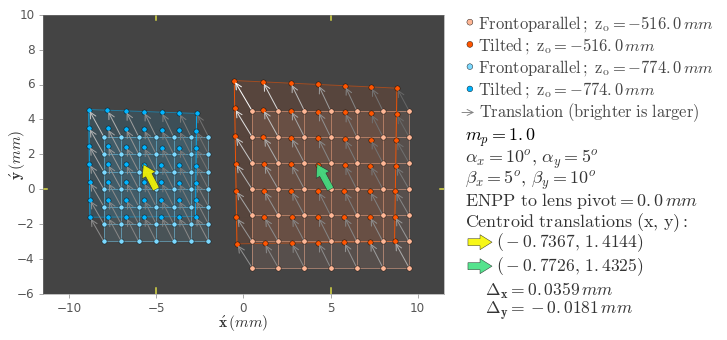

Object heights (mm): 92.2500005766


In [242]:
# *****************************
#       PLOT SETTINGS
# ****************************
# Set optical system
OPTICAL_SYSTEM = 2             # mp(1)=0.55 , mp(2)=1.0 or mp(not(1,2))=2.0
PIVOT_OFFSET = 0               # 0 or 5 mm from the ENPP (actual offset is -5)
COMPARE_PIVOT_OFFSET = True   # set OPTICAL_SYSTEM=2 set the particular PIVOT_OFFSET value = 0
TILT_UNOFFSET = False
SHOW_COMMON_LEGEND = True      # generally true only for the first image in a squence
DARK = True                    # theme is "dark" back ground or white
# ******************************

## Set tilts
if COMPARE_PIVOT_OFFSET:
    # to compare Pivot offset
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  0, 0, 25, 10 # with pivot_offset = 5, mp=1.0
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  10, 5, 0, 0   # with pivot_offset = 5, mp=1.0
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  5, 0, 20, 0   # with pivot_offset = 5, mp=1.0
    
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  10, 5, 0, 0 # with Pivot_offset = 0, mp=0.55, mp=1
    thetaXLens, thetaYLens, thetaXImage, thetaYImage =  10, 5, 5, 10 # with Pivot_offset = 0, mp=1
    
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 0, 0 # with Pivot_offset = 5, mp=1
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  10, 5, 0, 0 # with Pivot_offset = 0, mp=0.55,1,2
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  0, 0, 0, 0 
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  5, 0, 0, 0
else:
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  0, 0, 25, 10
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  10, 5, 0, 0
    thetaXLens, thetaYLens, thetaXImage, thetaYImage =  5, 0, 20, 0 
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  0, 0, 0, 0

assert PIVOT_OFFSET in (0, 5)

f = 24.0 # focal length
if OPTICAL_SYSTEM == 1: # mp = 0.550000000
    # Optical System 1
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -21.8363636 if PIVOT_OFFSET else -16.8363636
    zoDash = -7.4656319 if PIVOT_OFFSET else -2.4656319
    mp = 0.55
elif OPTICAL_SYSTEM == 2: # mp = 1.0
    # Optical System 2
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -13.0 if PIVOT_OFFSET else -8.0
    zoDash = 12.1707317 if PIVOT_OFFSET else 17.1707317
    mp = 1.0
else: # mp = 2.0
    # Optical System 3
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -25.0 if PIVOT_OFFSET else -20.0
    zoDash = 24.1707317 if PIVOT_OFFSET else 29.1707317
    mp = 2.0


# COMPUTATIONS
# ############

n = 7   # THIS NUMBER SHOULD BE ODD, in order to have the on-axis point (0,0)
nx = np.linspace(-1, 1, n)
hx, hy = np.meshgrid(nx, nx)
yDashNearMax = 4.5  # determines the extent of the image for near plane

# points for the near plane
# -------------------------
zeDash = zoDash - deDash
ze = -gm.pupil_centric_lens_formula(u=None, v=zeDash, f=f, mp=mp).u
yMax = abs(mp*(ze/zeDash)*yDashNearMax)

zNear = ze + de # ze = zo - de, where zo is zNear i.e object distance from pivot/coordinate origin

# points @ object plane Z1
XNear = np.vstack((yMax*hx.reshape(1, n**2), 
                   yMax*hy.reshape(1, n**2), 
                   zNear*np.ones((1, n**2))))

# image points for zero tilts @ object plane Z1
x1 = get_image_coordinates(XNear, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z1
x2 = get_image_coordinates(XNear, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)


# points for far plane
# --------------------

# Let the height of the image of the grid of points from the far plane be 
# equal to the second row (from top) of grid of points image from the near plane 
yDashFarMax = abs(x1[0, 1])  # determines the extent of the image for the far plane 

# What should be the object distance, zFar, if the object height is the same
# Since this plane is not in geometrical focus, we can't use the function
# get_image_coordinates(); so we use magnification relationship
mt = -yDashFarMax/yMax  # transverse magnification
ze = zeDash/(mp*mt)
zFar = ze + de # ze = zo + de where zo is zNear i.e object distance from pivot/coordinate origin

XFar = np.vstack((yMax*hx.reshape(1, n**2), 
                  yMax*hy.reshape(1, n**2), 
                  zFar*np.ones((1, n**2))))

# image points for zero tilts @ object plane Z2
x3 = get_image_coordinates_v2(XFar, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z2
x4 = get_image_coordinates_v2(XFar, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)

# compensation for tilt offset
tOffset = x2[:2, n**2 // 2] - x1[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 
#tOffset = x4[:2, n**2 // 2] - x3[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 

# displacement of center of mass of block @ Z1
cmDisplaceZ1x = np.sum(x2[0, :]/n**2) - np.sum(x1[0, :]/n**2)
cmDisplaceZ1y = np.sum(x2[1, :]/n**2) - np.sum(x1[1, :]/n**2)

# displacement of center of mass of block @ Z2
cmDisplaceZ2x = np.sum(x4[0, :]/n**2) - np.sum(x3[0, :]/n**2)
cmDisplaceZ2y = np.sum(x4[1, :]/n**2) - np.sum(x3[1, :]/n**2)

#print('CM displace @ Z1 = ({:5f}, {:5f})'.format(cmDisplaceZ1x, cmDisplaceZ1y))
#print('CM displace @ Z2 = ({:5f}, {:5f})'.format(cmDisplaceZ2x, cmDisplaceZ2y))

# FIGURE
# ######

figBGCol = '#444444' if DARK else '#FFFFFF'
#figBGCol = '#0576ED' if DARK else '#FFFFFF'   # Fun theme .... to try later

#fig, ax = plt.subplots(1, 1, figsize=(8.45, 5), dpi=200, facecolor=figBGCol)
fig, ax = plt.subplots(1, 1, figsize=(8.45, 5.), dpi=200) 
ax.set_axis_bgcolor(figBGCol)

# Scatter plots' marker colors coding
mcols = ['#FFB796', '#FF5500', '#7CD9FF', '#00B4FF']   # orange and blue
#mcols = ['#FF84A9', '#FF3F7A', '#7CD9FF', '#00B4FF']    # deep pink and blue

# Color for the arrows comparing the centroid displacement
#centDispArrCol = ['#68B04F', '#e64d8a']   # Near, Far # Green, Magenta 
centDispArrCol = ['#43E081', '#F7F700']   # Near, Far : Green, yellow


def get_v12NormMin_v12NormMax(a, b):
    v1 = np.hstack((a[0,:].reshape(n**2, 1), a[1,:].reshape(n**2, 1)))
    v2 = np.hstack((b[0,:].reshape(n**2, 1), b[1,:].reshape(n**2, 1)))
    v12Norm = np.linalg.norm(v2-v1, axis=1)
    return np.min(v12Norm), np.max(v12Norm)

def get_gray_level(vNorm, v12NormMin, v12NormMax):
    """
    Notes:
    where is vNorm in the scale between v12NormMin and v12NormMax?
    we can write: v12NormMin * (1 - a) + v12NormMax * a = vNorm
    Furthermore,
    if gl1 and gl2 are two gray levels (gl1 < gl2) and 0 <= gl1, gl2 <= 1
    gl = a * (gl2 - gl1) + gl1
    However, since we want darker shade to represent larger norm value,
    we return 1 - gl
    """
    global DARK
    deno = v12NormMax - v12NormMin
    a = (vNorm - v12NormMin)/deno if deno else 0.0
    gl1, gl2 = 0.4, 1.0
    gl = a * (gl2 - gl1) + gl1
    if DARK:
        return gl
    else:
        return 1.0 - gl

# Find the minimum and maximum arrow lengths 
arrNearMin, arrNearMax = get_v12NormMin_v12NormMax(x1, x2)
arrFarMin, arrFarMax = get_v12NormMin_v12NormMax(x3, x4)
minArrowLen, maxArrowLen = min(arrNearMin, arrFarMin), max(arrNearMax, arrFarMax)  


# Object plane at Z1
# ------------------
# displace plot for Z1 and Z2
xOffset, yOffset = 5, 0

ax.scatter(x1[0, :] + xOffset, x1[1, :] + yOffset, marker='o', s=28, 
           facecolor=mcols[0], edgecolor='k', lw=0.4, alpha=1.0, zorder=13,
           label=r'$\rm{{Frontoparallel}} \,;\,\,  z_o={{{:.1f}}}\, \it{{mm}}$'.format(zNear))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x1[0, i*n:(i+1)*n] + xOffset, 
                     y1=x1[1, i*n:(i+1)*n] + yOffset, 
                     y2=x1[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=mcols[0], edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x1[0, :][:n] + xOffset
yGridPts = x1[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=mcols[0], 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=mcols[0], 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x2[0, :] + xOffset - tOffset[0], x2[1, :] + yOffset - tOffset[1], 
           marker='o', s=28, facecolor=mcols[1], edgecolor='k', 
           lw=0.4, alpha=1.0, zorder=13, clip_on=False, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={{{:.1f}}}\, \it{{mm}}$'.format(zNear))

# shade region to show the span of the grid of points
for i in range(n-1):
    x_row1 = x2[0, i*n:(i+1)*n] + xOffset
    x_row2 = x2[0, (i+1)*n:(i+2)*n] + xOffset
    y_row1 = x2[1, i*n:(i+1)*n] + yOffset
    y_row2 = x2[1, (i+1)*n:(i+2)*n] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=mcols[1], 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)

# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):    
    #minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x1, x2)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x2[0, i] - x1[0, i])**2 +  (x2[1, i] - x1[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x2[0, i] + xOffset, x2[1, i] + yOffset), 
                    xytext=(x1[0, i] + xOffset, x1[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color=arrCol, linewidth=1.0, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)
    
# draw outer boundery
ax.plot(x2[0, :n] + xOffset - tOffset[0], x2[1, :n], color=mcols[1], 
        lw=0.9, zorder=2, alpha=0.5, clip_on=False) # top
ax.plot(x2[0, -n::] + xOffset - tOffset[0], x2[1, -n::], color=mcols[1], 
        lw=0.9, zorder=2, alpha=0.5,  clip_on=False) # bottom
ax.plot(x2[0, n-1::n] + xOffset - tOffset[0], x2[1, n-1::n], color=mcols[1], 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # left side
ax.plot(x2[0, ::n] + xOffset - tOffset[0], x2[1, ::n], color=mcols[1], 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # right side

if COMPARE_PIVOT_OFFSET:
    # displacement vector of the centroid
    ax.annotate("", xy=(np.sum(x2[0, :]/n**2) + xOffset, np.sum(x2[1, :]/n**2) + yOffset), 
                xytext=(np.sum(x1[0, :]/n**2) + xOffset, np.sum(x1[1, :]/n**2) + yOffset),
                arrowprops=dict(fc=centDispArrCol[0], ec='#222222', linewidth=0.5, headwidth=15, 
                                width=7, alpha=0.9),
                annotation_clip=False, zorder=16)   

# Object plane at Z2
# ------------------
xOffset, yOffset = -5, 0

ax.scatter(x3[0, :] + xOffset, x3[1, :] + yOffset, marker='o', s=26, 
           facecolor=mcols[2], edgecolor='k', lw=0.4, alpha=1.0, zorder=12,
           label=r'$\rm{{Frontoparallel}} \,;\, \, z_o={{{:.1f}}}\,\it{{mm}}$'.format(zFar))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x3[0, i*n:(i+1)*n] + xOffset, 
                     y1=x3[1, i*n:(i+1)*n] + yOffset, 
                     y2=x3[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=mcols[2], edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x3[0, :][:n] + xOffset
yGridPts = x3[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=mcols[2], 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=mcols[2], 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x4[0, :] + xOffset - tOffset[0], x4[1, :] + yOffset - tOffset[1], 
           marker='o', s=26, facecolor=mcols[3], edgecolor='k', 
           lw=0.4, alpha=1.0, clip_on=False, zorder=12, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={{{:.1f}}}\, \it{{mm}}$'.format(zFar))

# shade region to show the span of the grid of points
for i in range(n-1):
    x_row1 = x4[0, i*n:(i+1)*n] + xOffset
    x_row2 = x4[0, (i+1)*n:(i+2)*n] + xOffset
    y_row1 = x4[1, i*n:(i+1)*n] + yOffset
    y_row2 = x4[1, (i+1)*n:(i+2)*n] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=mcols[3], 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)

# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):
    #minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x3, x4)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x4[0, i] - x3[0, i])**2 +  (x4[1, i] - x3[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x4[0, i] + xOffset, x4[1, i] + yOffset), 
                    xytext=(x3[0, i] + xOffset, x3[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color= arrCol, linewidth=1.0, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)

# draw outer boundery
ax.plot(x4[0, :n] + xOffset - tOffset[0], x4[1, :n], color=mcols[3], 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # top
ax.plot(x4[0, -n::] + xOffset - tOffset[0], x4[1, -n::], color=mcols[3], 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # bottom
ax.plot(x4[0, n-1::n] + xOffset - tOffset[0], x4[1, n-1::n], color=mcols[3], 
        clip_on=False, alpha=0.9, lw=1.0, zorder=2) # left side
ax.plot(x4[0, ::n] + xOffset - tOffset[0], x4[1, ::n], color=mcols[3], 
        lw=1.0, alpha=0.9, clip_on=False, zorder=2) # right side

if COMPARE_PIVOT_OFFSET:
    # displacement vector
    ax.annotate("", xy=(np.sum(x4[0, :]/n**2) + xOffset, np.sum(x4[1, :]/n**2) + yOffset), 
                   xytext=(np.sum(x3[0, :]/n**2) + xOffset, np.sum(x3[1, :]/n**2) + yOffset),
                 arrowprops=dict(fc=centDispArrCol[1], ec='#222222', linewidth=0.5, headwidth=15, 
                                 width=7, alpha=0.9),
                        annotation_clip=False, zorder=16) 

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-6, 10)
ax.set_aspect('equal')

ax.set_ylabel(r'$\'{\bf{y}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-10)
ax.set_xlabel(r'$\'{\bf{x}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-2)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#ax.grid()

# draw center markers
#ctrMCol = '#BBBBBB' if DARK else '#444444'
ctrMCol = '#DDDD44' if DARK else '#444444'
ax.axvline(x=xOffset, ymin=0, ymax=0.02, lw=1.5, color=ctrMCol)
ax.axvline(x=-xOffset, ymin=0, ymax=0.02, lw=1.5, color=ctrMCol)
ax.axvline(x=xOffset, ymin=0.98, ymax=1, lw=1.5, color=ctrMCol)
ax.axvline(x=-xOffset, ymin=0.98, ymax=1, lw=1.5, color=ctrMCol)

ax.axhline(y=yOffset, xmin=0, xmax=0.01, lw=1.5, color=ctrMCol)
ax.axhline(y=yOffset, xmin=0.99, xmax=1, lw=1.5, color=ctrMCol)

txt1 = r'$m_p ={}$'.format(mp)
txt2 = r'$\alpha_{{x}} ={}^o, \, \alpha_{{y}} ={}^o$'.format(thetaXLens, thetaYLens)   
txt3 = r'$\beta_{{x}} ={}^o, \, \beta_{{y}} ={}^o$'.format(thetaXImage, thetaYImage) 
txt4 = r'$\rm{{ENPP}}\,\,\rm{{to}}\,\,\rm{{lens}}\,\,\rm{{pivot}} =  {} \,\it{{mm}}$'.format(de)
txt5 = r'$\rm{Centroid}\,\, \rm{translations} \,\, \rm{(x,}\, \rm{y):}$'
s1, s2 = '{: .4f}'.format(cmDisplaceZ2x), '{: .4f}'.format(cmDisplaceZ2y)
txt6 = r'$({},\, {})$'.format(s1, s2)
s1, s2 = '{: .4f}'.format(cmDisplaceZ1x), '{: .4f}'.format(cmDisplaceZ1y)
txt7 = r'$({},\, {})$'.format(s1, s2)
txt8 = r'$\bf{{\Delta_x = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2x - cmDisplaceZ1x)
txt9 = r'$\bf{{\Delta_y = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2y - cmDisplaceZ1y)

# at top right (outside the axes)

txtOff = -0.31 if SHOW_COMMON_LEGEND else 0
transArrowLegOff = 0 if SHOW_COMMON_LEGEND else 0.0899

fig.text(0.877, 0.86 + txtOff, txt1, fontsize=18, color='#000000')
fig.text(0.877, 0.80 + txtOff, txt2, fontsize=18, color='#333333')
fig.text(0.877, 0.74 + txtOff, txt3, fontsize=18, color='#333333')
fig.text(0.877, 0.68 + txtOff, txt4, fontsize=18, color='#333333')
fig.text(0.877, 0.62 + txtOff, txt5, fontsize=18, color='#333333')
fig.text(0.927, 0.566 + txtOff, txt6, fontsize=17.5, color='#333333')
fig.text(0.927, 0.499 + txtOff, txt7, fontsize=17.5, color='#333333')
ax.annotate("", xy=(1.12, 0.495 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
            xytext=(1.06, 0.495 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
            arrowprops=dict(fc=centDispArrCol[1], ec='#222222', linewidth=0.5, headwidth=15, 
                            width=7, alpha=0.9,),      
            annotation_clip=False, zorder=12)
ax.annotate("", xy=(1.12, 0.409 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
            xytext=(1.06, 0.409 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
            arrowprops=dict(fc=centDispArrCol[0], ec='#222222', linewidth=0.5, headwidth=15,
                            width=7, alpha=0.9),      
            annotation_clip=False, zorder=12)
if (mp==1 and thetaXImage==0 and thetaYImage==0):
    fig.text(0.91, 0.43 + txtOff, txt8, fontsize=17.5, color='#D13A3D')
    fig.text(0.91, 0.38 + txtOff, txt9, fontsize=17.5, color='#D13A3D')
else:
    fig.text(0.91, 0.43 + txtOff, txt8, fontsize=17.5, color='#333333')
    fig.text(0.91, 0.38 + txtOff, txt9, fontsize=17.5, color='#333333')
    
# Legend
#r'$\rm{{Frontoparallel}} \,;\,\,  z_o={}\, \it{{mm}}$'
if SHOW_COMMON_LEGEND:
    t = 0 if COMPARE_PIVOT_OFFSET else -0.0  # adjustment required because xlims are not exactly the same
    ax.annotate(r'$\rm{Translation}\,\, \rm{(brighter}\,\,\rm{is}\,\,\rm{larger)}$', 
                xy=(1.04 + t, 0.65), xycoords='axes fraction',
                xytext=(1.0865 + t, 0.65), textcoords='axes fraction', 
                arrowprops=dict(arrowstyle='<-', color= '0.5', linewidth=0.9, mutation_scale=15), 
                va='center', annotation_clip=False, fontsize=16.5, zorder=15)

    ax.legend(fontsize=16.5, scatterpoints=1, markerscale=1.12, scatteryoffsets=[0.5],
              ncol=1, loc='upper right', bbox_to_anchor=(1.31, 0.945), labelspacing=0.14,
              bbox_transform=fig.transFigure, handletextpad=0.38, handlelength=0.2)

# Save the figure  
#saveFigure(fig, 'distortion_grid_33.png')
#saveFigure(fig, 'centroid_translations_4_3.png')

plt.show()

print('Object heights (mm):', yMax) # they must be of equal height

[START OF PLOT CODE](#Plots:-Type-2)

[Start of Type 1 plot code](#Plots:-Type-1)

[Start of Type 2, plot 2](#Closer-look-at-the-shift-of-image-points)

### Closer look at the shift of image points

The following plot makes use of the data from the previous plot/data. 

figname: C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\images\parallax_4_3.png


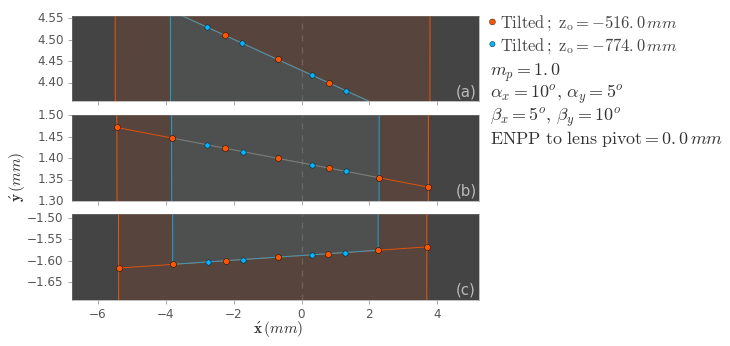

In [236]:
# FIGURE
# ######

#fig, ax = plt.subplots(1, 1, figsize=(8.45, 5), dpi=200, facecolor=figBGCol)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6.5, 4.5), sharex=True, dpi=200)
#fig = plt.figure(figsize=(7, 4.5), sharex=True, dpi=200)

for ax in [ax1, ax2, ax3]:
    ax.set_axis_bgcolor(figBGCol)

    # Object plane at Z1
    # ------------------
    # finite tilts
    line1 = ax.scatter(x2[0, :], x2[1, :], marker='o', s=35, facecolor=mcols[1], edgecolor='k', 
                       lw=0.4, alpha=1.0, zorder=13,)
    label1=r'$\rm{{Tilted}} \,;\,\, z_o={{{:.1f}}}\, \it{{mm}}$'.format(zNear)
    
    # shade region to show the span of the grid of points
    for i in range(n-1):
        x_row1 = x2[0, i*n:(i+1)*n] 
        x_row2 = x2[0, (i+1)*n:(i+2)*n] 
        y_row1 = x2[1, i*n:(i+1)*n] 
        y_row2 = x2[1, (i+1)*n:(i+2)*n] 
        # we need to reverse the order of points from the second row
        # so that the order of points (at the transition between rows) 
        # is circular and not zig-zag
        x_pts = np.concatenate((x_row1, x_row2[::-1]))
        y_pts = np.concatenate((y_row1, y_row2[::-1]))
        k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
        patch = mpatches.Polygon(xy=k, closed=True, facecolor=mcols[1], 
                                 edgecolor='none', alpha=0.1, zorder=3, clip_on=True)
        ax.add_patch(patch)

    # draw outer boundery
    ax.plot(x2[0, :n], x2[1, :n], color=mcols[1], lw=1.0, zorder=2, alpha=0.8) # top
    ax.plot(x2[0, -n::], x2[1, -n::], color=mcols[1], lw=1.0, zorder=2, alpha=0.8) # bottom
    ax.plot(x2[0, n-1::n], x2[1, n-1::n], color=mcols[1], lw=1.0, zorder=2, alpha=0.9,) # left side
    ax.plot(x2[0, ::n], x2[1, ::n], color=mcols[1], lw=1.0, zorder=2, alpha=0.9) # right side
    
    # Draw the second row from top, middle row, and second last row
    for i in [1, 3, 5]:
        ax.plot(x2[0, i*n:(i+1)*n], x2[1, i*n:(i+1)*n], color=mcols[1], lw=1.0, zorder=2, alpha=0.8) 


    # Object plane at Z2
    # ------------------
    # finite tilts
    line2 = ax.scatter(x4[0, :], x4[1, :], marker='o', s=28, facecolor=mcols[3], edgecolor='k', 
                       lw=0.4, alpha=1.0, clip_on=True, zorder=12, )
    label2 = r'$\rm{{Tilted}} \,;\,\, z_o={{{:.1f}}}\, \it{{mm}}$'.format(zFar)

    # shade region to show the span of the grid of points
    for i in range(n-1):
        x_row1 = x4[0, i*n:(i+1)*n]  
        x_row2 = x4[0, (i+1)*n:(i+2)*n]  
        y_row1 = x4[1, i*n:(i+1)*n]  
        y_row2 = x4[1, (i+1)*n:(i+2)*n]  
        # we need to reverse the order of points from the second row
        # so that the order of points (at the transition between rows) 
        # is circular and not zig-zag
        x_pts = np.concatenate((x_row1, x_row2[::-1]))
        y_pts = np.concatenate((y_row1, y_row2[::-1]))
        k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
        patch = mpatches.Polygon(xy=k, closed=True, facecolor=mcols[3], 
                                 edgecolor='none', alpha=0.1, zorder=3, clip_on=True)
        ax.add_patch(patch)

    # draw outer boundery (for the 3 axes)
    ax.plot(x4[0, :n], x4[1, :n], color=mcols[3], lw=1.0, alpha=0.8, zorder=2) # top
    ax.plot(x4[0, 3*n:4*n], x4[1, 3*n:4*n], color=mcols[3], lw=1.0, alpha=0.5, zorder=2) # middle
    ax.plot(x4[0, -n::], x4[1, -n::], color=mcols[3], lw=1.0, alpha=0.8, zorder=2) # bottom
    ax.plot(x4[0, n-1::n], x4[1, n-1::n], color=mcols[3], alpha=0.9, lw=1.0, zorder=2) # left side
    ax.plot(x4[0, ::n], x4[1, ::n], color=mcols[3], lw=1.0, alpha=0.9, zorder=2) # right side
    
    ax.axvline(x=0, linestyle='dashed', color='#AAAAAA', lw=1.3, zorder=1, alpha=0.3)

# Set y-limits
if (thetaXImage==25 and thetaYImage > 0 and thetaXLens==0 and thetaYLens==0):
    bandHeight = 1.0
else:
    bandHeight = 0.2
  
yOffset1 = 0.5*(np.mean(x2[1, n:2*n]) + np.mean(x4[1, 0:n])) - bandHeight/2.
yOffset2 = 0.5*(np.mean(x2[1, 3*n:4*n]) + np.mean(x4[1, 3*n:4*n])) - bandHeight/2.0
yOffset3 = 0.5*(np.mean(x2[1, 5*n:6*n]) + np.mean(x4[1, 6*n:7*n])) - bandHeight/2.0

ax1.set_ylim(yOffset1, yOffset1 + bandHeight)
ax2.set_ylim(yOffset2, yOffset2 + bandHeight)
ax3.set_ylim(yOffset3, yOffset3 + bandHeight)

bandWidth = 12
xLimMin = np.mean(x2[0, 3*n:4*n])

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(xLimMin - bandWidth/2., xLimMin + bandWidth/2.) 
    
ylabel = r'$\'{\bf{y}} \,\it{(mm)}$'
xlabel = r'$\'{\bf{x}} \,\it{(mm)}$'
fig.text(-0.025, 0.5, ylabel, rotation='vertical', fontsize=15.5, color='#333333',)
fig.text(0.5, -0.015, xlabel, fontsize=15.5, color='#333333',)

for l, ax in zip(['(a)', '(b)', '(c)'], [ax1, ax2, ax3]):
    ax.text(.944, 0.065, l, fontsize=15, color='#BBBBBB', transform=ax.transAxes)

for ax in [ax1, ax2, ax3]:
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

txt1 = r'$m_p ={}$'.format(mp)
txt2 = r'$\alpha_{{x}} ={}^o, \, \alpha_{{y}} ={}^o$'.format(thetaXLens, thetaYLens)   
txt3 = r'$\beta_{{x}} ={}^o, \, \beta_{{y}} ={}^o$'.format(thetaXImage, thetaYImage) 
txt4 = r'$\rm{{ENPP}}\,\,\rm{{to}}\,\,\rm{{lens}}\,\,\rm{{pivot}} =  {} \,\it{{mm}}$'.format(de)
txt5 = r'$\rm{Centroid}\,\, \rm{translations} \,\, \rm{(x,}\, \rm{y):}$'

# at top right (outside the axes)
fig.text(1.006, 0.78, txt1, fontsize=18, color='#333333')
fig.text(1.006, 0.71, txt2, fontsize=18, color='#333333')
fig.text(1.006, 0.64, txt3, fontsize=18, color='#333333')
fig.text(1.006, 0.57, txt4, fontsize=18, color='#333333')

# create legend
#lx = 0.645 
lx = 0.663

fig.legend((line1, line2), (label1, label2), loc=(lx, 0.82), scatteryoffsets=[0.5],
           fontsize=16.5, scatterpoints=1, markerscale=1.0, labelspacing=0.14,
           handletextpad=0.38, handlelength=0.2)

plt.tight_layout(pad=0.8)

# Save the figure  
#saveFigure(fig, 'parallax_4_3.png')

plt.show()

[Start of Type 2 plot code](#Plots:-Type-2)

[Start of Type 1 plot code](#Plots:-Type-1)